# Autoencoder-based anomaly detection

Inspired from [this notebook](https://www.kaggle.com/code/ohseokkim/dectecting-anomaly-using-autoencoder/notebook). Good paper to get a grasp on autoencoder based anomaly detection: [Salahuddin, M. A., Bari, M. F., Alameddine, H. A., Pourahmadi, V., & Boutaba, R. (2020, November). Time-based anomaly detection using autoencoder. In 2020 16th International Conference on Network and Service Management (CNSM) (pp. 1-9). IEEE.](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9269112&casa_token=O9Sd7VMcqcMAAAAA:1seV80TTrdLcBICgcZa8qrH5qbsoTZUB67PaIW61Tb5jRJLqH1O1sJ9hqEmC1zJNPVU8XSb7lJU)

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

## Introduction

### What is Autoencoder?

![](https://lilianweng.github.io/lil-log/assets/images/autoencoder-architecture.png)

Picture credit: https://lilianweng.github.io

Autoencoder learns to produce the same output as the input as much as possible. It learns the representation of the input by compressing it to a lower dimension latent space, which is the encoder part of the model. Then it reconstructs the input to a higher dimension output that is ideally identical to the original input, which is the decoder part of the model.

### Autoencoder-based anomaly detection

Autoencoder-based anomaly detection is to perform anomaly detection by compressing the normal data into a lower dimension latent space, then reconstructing it back to higher dimension, minimizing the difference between the output and original input. The difference is called the **reconstruction loss**.

Through the learning process, the model will effectively learn the representations of the normal samples, and will be able to reconstruct normal samples well. However, the model will not be able to reconstruct the anomalies well because it didn't learn the representations of anomalies. Thus, **normal samples will naturally have lower reconstruction loss than the anomalies**, which can be used as **anomaly score**, where higher the score, the more abnormal the data is.

Anomaly detection can then be performed with a predetermined **threshold**, where any instance with **reconstruction loss greater than the threshold is considered as anomaly**.

## Dataset overview

The dataset consists ECG recordings sourced from Physionet's PTB Diagnostic Database. These ECG signals are categorized into two classes: normal heartbeats and those affected by cardiac abnormalities. Each row corresponds to a single complete ECG of a patient. Every single ECG is composed of 140 data points (readings).

In [74]:
df = pd.read_csv('/kaggle/input/ecg-dataset/ecg.csv', header=None)  # the last column is the label(1: normal, 0: abnormal)
df[140] = df[140].replace({1.0: 'Normal', 0.0: 'Abnormal'})
df

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,Normal
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,Normal
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,Normal
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,Normal
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4993,0.608558,-0.335651,-0.990948,-1.784153,-2.626145,-2.957065,-2.931897,-2.664816,-2.090137,-1.461841,...,1.757705,2.291923,2.704595,2.451519,2.017396,1.704358,1.688542,1.629593,1.342651,Abnormal
4994,-2.060402,-2.860116,-3.405074,-3.748719,-3.513561,-3.006545,-2.234850,-1.593270,-1.075279,-0.976047,...,1.388947,2.079675,2.433375,2.159484,1.819747,1.534767,1.696818,1.483832,1.047612,Abnormal
4995,-1.122969,-2.252925,-2.867628,-3.358605,-3.167849,-2.638360,-1.664162,-0.935655,-0.866953,-0.645363,...,-0.472419,-1.310147,-2.029521,-3.221294,-4.176790,-4.009720,-2.874136,-2.008369,-1.808334,Abnormal
4996,-0.547705,-1.889545,-2.839779,-3.457912,-3.929149,-3.966026,-3.492560,-2.695270,-1.849691,-1.374321,...,1.258419,1.907530,2.280888,1.895242,1.437702,1.193433,1.261335,1.150449,0.804932,Abnormal


In [75]:
df[140].value_counts()  # counts

Normal      2919
Abnormal    2079
Name: 140, dtype: int64

In [76]:
df[140].value_counts()/df.shape[0]  # percentage

Normal      0.584034
Abnormal    0.415966
Name: 140, dtype: float64

The distribution doesn't seem to be imbalanced, although class imbalance is often in many cases.

## Preprocessing

### MinMaxScaling

Before feeding the data into the AutoEncoder the data must definitely be **scaled between 0 and 1** using MinMaxScaler since we are going to use sigmoid activation function in the output layer which outputs values between 0 and 1.

In [77]:
# converting the labels back to integers
df[140] = df[140].replace({'Normal': 1, 'Abnormal': 0})

X = df.values[:, :-1]
y = df.values[:, -1]

In [78]:
# MinMaxScaling
min_val = tf.reduce_min(X)
max_val = tf.reduce_max(X)

X_s = (X - min_val) / (max_val - min_val)

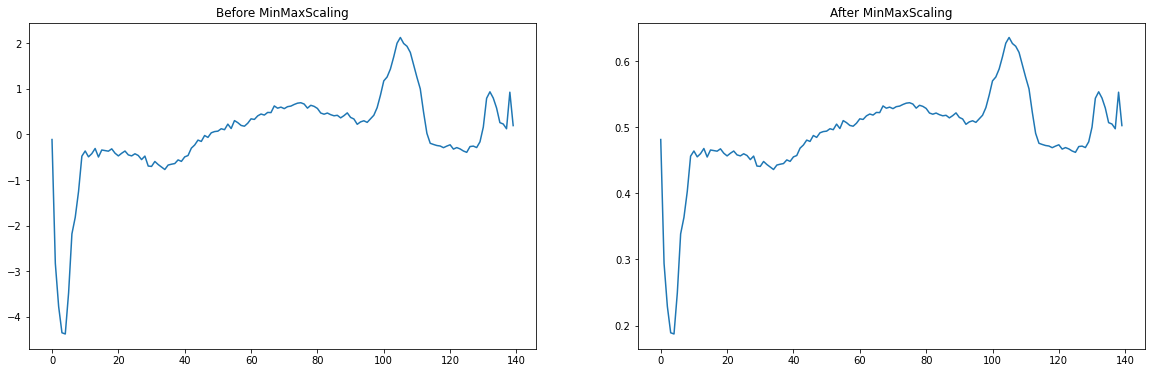

In [79]:
fig, ax = plt.subplots(1, 2, figsize = (20, 6))
sns.lineplot(range(len(X[0])), X[0], ax = ax[0]).set(title = 'Before MinMaxScaling');
sns.lineplot(range(len(X_s[0])), X_s[0], ax = ax[1]).set(title = 'After MinMaxScaling');

We can see that MinMaxScaling does not affect the shape of the distribution.

### Train test split

In [80]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X_s), y, test_size = 0.3, random_state = 42)

In [81]:
X_train.shape, X_test.shape

((3498, 140), (1500, 140))

### Normal train samples

We are going to train the autoencoder using only the normal samples, so we should split the train samples from normal and abnormal samples.

In [82]:
X_train_normal = X_train[y_train.astype(bool)]
X_train_normal.shape

(2041, 140)

In [83]:
X_train_abnormal = X_train[~y_train.astype(bool)]
X_train_abnormal.shape

(1457, 140)

## EDA

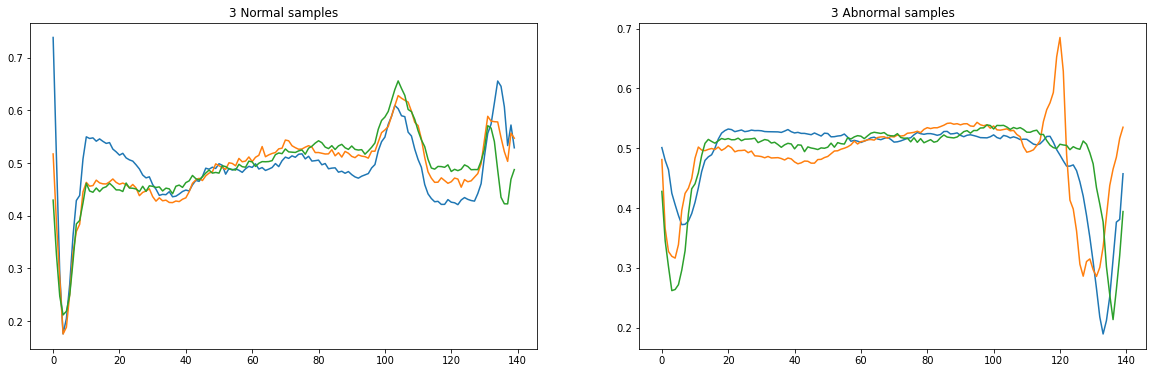

In [84]:
fig, ax = plt.subplots(1, 2, figsize = (20, 6))
sns.lineplot(range(len(X_train_normal[0])), X_train_normal[0], ax = ax[0]).set(title = '3 Normal samples');
sns.lineplot(range(len(X_train_normal[1])), X_train_normal[1], ax = ax[0]);
sns.lineplot(range(len(X_train_normal[2])), X_train_normal[2], ax = ax[0]);
sns.lineplot(range(len(X_train_abnormal[0])), X_train_abnormal[0], ax = ax[1]).set(title = '3 Abnormal samples');
sns.lineplot(range(len(X_train_abnormal[1])), X_train_abnormal[1], ax = ax[1]);
sns.lineplot(range(len(X_train_abnormal[2])), X_train_abnormal[2], ax = ax[1]);

We can easily see the difference between the normal and abnormal samples by visual.

## Modeling

### Creating autoencoder

In [85]:
class AutoEncoder(Model):
    def __init__(self, name = 'auto_encoder', **kwargs):
        super(AutoEncoder, self).__init__(name = name, **kwargs)
        self.encoder = tf.keras.Sequential([
            layers.Dense(32, activation="relu"),
            layers.Dense(16, activation="relu"),
            layers.Dense(8, activation="relu")],
            name = 'encoder'
        )
        
        self.decoder = tf.keras.Sequential([
            layers.Dense(16, activation="relu"),
            layers.Dense(32, activation="relu"),
            layers.Dense(140, activation="sigmoid")], # 140 is the length of the sequence
            name = 'decoder'
        )
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [86]:
autoencoder = AutoEncoder()
autoencoder.compile(optimizer='adam', loss='mae')
autoencoder.build((None, 140))

In [87]:
autoencoder.summary()

Model: "auto_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 8)                 5176      
_________________________________________________________________
decoder (Sequential)         (None, 140)               5308      
Total params: 10,484
Trainable params: 10,484
Non-trainable params: 0
_________________________________________________________________


### Training

The autoenoder will be trained on normal samples only, and will be evaluated on the full test set.

In [88]:
callback = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)

history = autoencoder.fit(X_train_normal, X_train_normal,  # the output should be as similar to its original sequence
                          epochs = 100, 
                          callbacks = [callback],
                          batch_size = 512, 
                          validation_data = (X_test, X_test), 
                          shuffle = True)

Epoch 1/100
4/4 [==============================] - 1s 74ms/step - loss: 0.0454 - val_loss: 0.0431
Epoch 2/100
4/4 [==============================] - 0s 20ms/step - loss: 0.0433 - val_loss: 0.0420
Epoch 3/100
4/4 [==============================] - 0s 20ms/step - loss: 0.0414 - val_loss: 0.0409
Epoch 4/100
4/4 [==============================] - 0s 19ms/step - loss: 0.0393 - val_loss: 0.0399
Epoch 5/100
4/4 [==============================] - 0s 19ms/step - loss: 0.0373 - val_loss: 0.0389
Epoch 6/100
4/4 [==============================] - 0s 22ms/step - loss: 0.0354 - val_loss: 0.0382
Epoch 7/100
4/4 [==============================] - 0s 20ms/step - loss: 0.0336 - val_loss: 0.0374
Epoch 8/100
4/4 [==============================] - 0s 18ms/step - loss: 0.0319 - val_loss: 0.0369
Epoch 9/100
4/4 [==============================] - 0s 18ms/step - loss: 0.0305 - val_loss: 0.0363
Epoch 10/100
4/4 [==============================] - 0s 22ms/step - loss: 0.0291 - val_loss: 0.0359
Epoch 11/100
4/4 [=

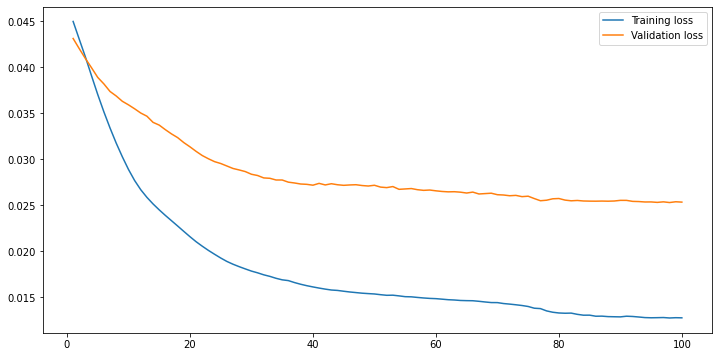

In [89]:
fig, ax = plt.subplots(figsize = (12, 6))
n = len(history.history['loss'])
sns.lineplot(range(1, n + 1), history.history['loss'], label = 'Training loss');
sns.lineplot(range(1, n + 1), history.history['val_loss'], label = 'Validation loss');

### Visualizing the autoencoder on normal samples

Let's first see if the model has been trained properly so that it reconstructs the normal data well.

In [90]:
encoded = autoencoder.encoder(X_train_normal).numpy()
decoded = autoencoder.decoder(encoded).numpy()

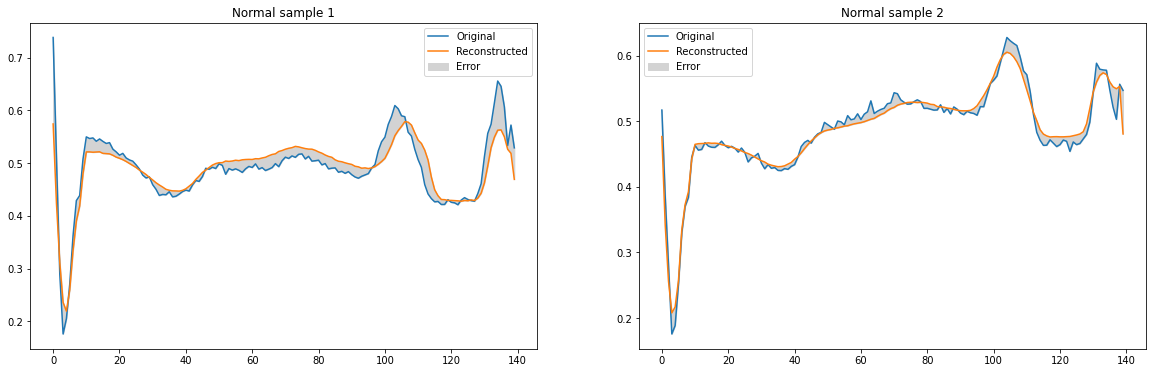

In [91]:
fig, ax = plt.subplots(1, 2, figsize = (20, 6))
n = len(X_train_normal[0])
sns.lineplot(range(n), X_train_normal[0], label = 'Original', ax = ax[0]).set(title = 'Normal sample 1');
sns.lineplot(range(n), decoded[0], label = 'Reconstructed', ax = ax[0]);
ax[0].fill_between(range(n), X_train_normal[0], decoded[0], color = 'lightgray');
ax[0].legend(labels = ['Original', 'Reconstructed', 'Error']);

sns.lineplot(range(n), X_train_normal[1], label = 'Original', ax = ax[1]).set(title = 'Normal sample 2');
sns.lineplot(range(n), decoded[1], label = 'Reconstructed', ax = ax[1]);
ax[1].fill_between(range(n), X_train_normal[1], decoded[1], color = 'lightgray');
ax[1].legend(labels = ['Original', 'Reconstructed', 'Error']);

We can see that the autoencoder has learned the representations of normal samples, and was able to reconstruct the samples well.

### Visualizing autoencoder on abnormal samples

In [92]:
encoded = autoencoder.encoder(X_train_abnormal).numpy()
decoded = autoencoder.decoder(encoded).numpy()

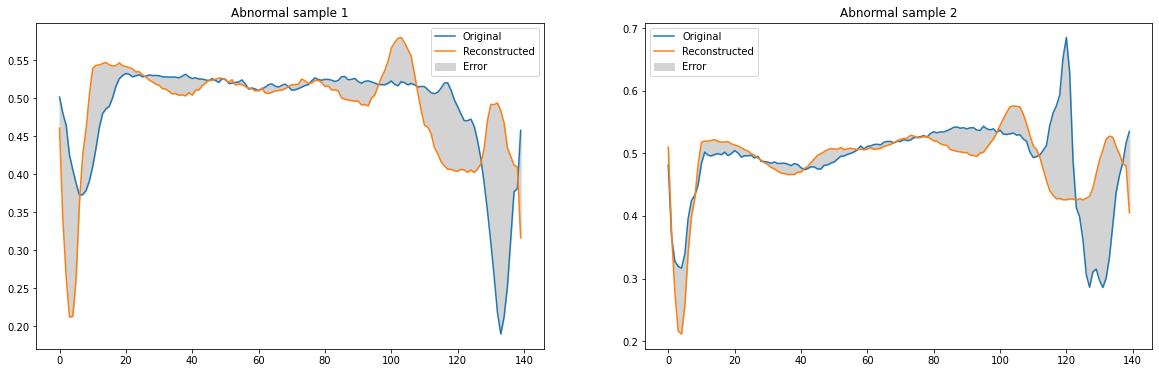

In [93]:
fig, ax = plt.subplots(1, 2, figsize = (20, 6))
n = len(X_train_normal[0])
sns.lineplot(range(n), X_train_abnormal[0], label = 'Original', ax = ax[0]).set(title = 'Abnormal sample 1');
sns.lineplot(range(n), decoded[0], label = 'Reconstructed', ax = ax[0]);
ax[0].fill_between(range(n), X_train_abnormal[0], decoded[0], color = 'lightgray');
ax[0].legend(labels = ['Original', 'Reconstructed', 'Error']);

sns.lineplot(range(n), X_train_abnormal[1], label = 'Original', ax = ax[1]).set(title = 'Abnormal sample 2');
sns.lineplot(range(n), decoded[1], label = 'Reconstructed', ax = ax[1]);
ax[1].fill_between(range(n), X_train_abnormal[1], decoded[1], color = 'lightgray');
ax[1].legend(labels = ['Original', 'Reconstructed', 'Error']);

We can see that the autoencoder was not able to reconstruct the abnormal samples well, which is expected as the abnormal samples deviate from the representations of normal samples.

## Anomaly detection threshold

We consider a sample an anomaly if its **reconstruction loss** (MAE of train and reconstructed samples in this case) is **greater than a fixed threshold**. 

Let's first set the threshold as one standard deviation above the mean reconstruction loss of normal samples.

In [94]:
# Calculating reconstruction loss for normal samples
reconstructions = autoencoder.predict(X_train_normal)
reconstruction_loss = tf.keras.losses.mae(reconstructions, X_train_normal)

In [95]:
# Summary statistics of reconstruction loss of normal samples
re_loss_stats = pd.DataFrame(reconstruction_loss).describe().transpose()
re_loss_stats

,count,mean,std,min,25%,50%,75%,max
0,2041.0,0.012774,0.006525,0.004508,0.009046,0.011167,0.014418,0.061143


In [96]:
# Threshold as 1 standard deviation greater than mean reconstruction loss of normal samples
threshold1 = re_loss_stats['mean'][0] + 1*re_loss_stats['std'][0]
threshold2 = re_loss_stats['mean'][0] + 2*re_loss_stats['std'][0]
print(f"Threshold 1 value: {threshold1: .6f}")
print(f"Threshold 2 value: {threshold2: .6f}")

Threshold 1 value:  0.019299
Threshold 2 value:  0.025824


In [97]:
# Calculating reconstruction loss for abnormal samples
recons_abnormal = autoencoder.predict(X_train_abnormal)
recons_loss_abnormal = tf.keras.losses.mae(recons_abnormal, X_train_abnormal)

In [98]:
# Summary statistics of reconstruction loss of abnormal samples
re_loss_abnormal_stats = pd.DataFrame(recons_loss_abnormal).describe().transpose()
re_loss_abnormal_stats

,count,mean,std,min,25%,50%,75%,max
0,1457.0,0.042874,0.005958,0.009427,0.03969,0.042673,0.04588,0.084203


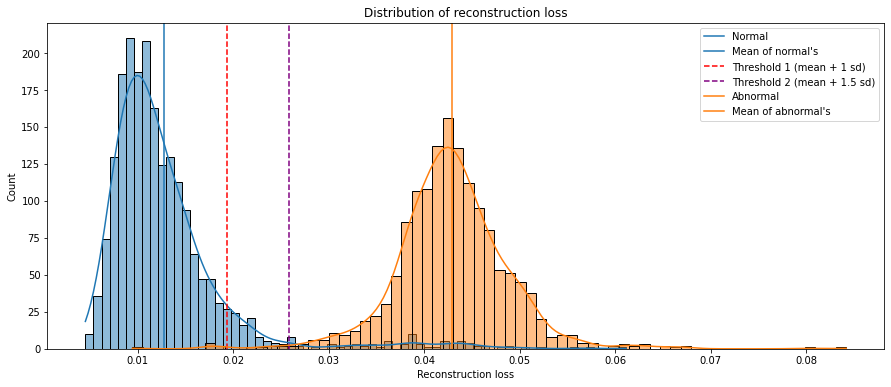

In [99]:
fig, ax = plt.subplots(figsize = (15, 6))
sns.histplot(reconstruction_loss, kde = True, color = 'tab:blue').set(title = 'Distribution of reconstruction loss', xlabel = 'Reconstruction loss');
plt.axvline(re_loss_stats['mean'][0], color = 'tab:blue');
plt.axvline(threshold1, color = 'red', linestyle = '--');
plt.axvline(threshold2, color = 'purple', linestyle = '--');
sns.histplot(recons_loss_abnormal, kde = True, color = 'tab:orange');
plt.axvline(re_loss_abnormal_stats['mean'][0], color = 'tab:orange')
plt.legend(labels = ['Normal', 'Mean of normal\'s', 'Threshold 1 (mean + 1 sd)', 'Threshold 2 (mean + 1.5 sd)', 'Abnormal', 'Mean of abnormal\'s']);

We can see that many of the normal samples are within the threshold and most of the abnormal samples are outside the threshold. However, with this threshold, seems to be quite plenty of normal samples outside the threshold as well. So we might consider configuring the optimal threshold value.

When configuring the threshold, we want to **increase Recall** in anomaly detection because we **want to detect as many anomalies as possible** (even more urgent if the cost of anomalies is great). However, focusing solely on Recall will **decrease Precision** which will generate **more false positives**.

The optimal balance depends on the specific context and the relative costs of false negatives (missed anomalies) vs false positives (normal instances flagged as anomalies).

## Prediction

In [100]:
def predict(model, data, threshold):
    reconstructions = model(data)
    loss = tf.keras.losses.mae(reconstructions, data)
    return tf.math.less(loss, threshold)

def print_stats(labels, preds):
    print(f"Accuracy = {accuracy_score(labels, preds): .5f}")
    print(f"Precision = {precision_score(labels, preds, pos_label = 0): .5f}")  # TP / (TP + FP)
    print(f"Recall = {recall_score(labels, preds, pos_label = 0): .5f}")  # TP / (TP + FN)
    print(f"F1 score = {f1_score(labels, preds, pos_label = 0): .5f}")  # the harmonic mean of precision and recall

### Prediction with threshold 1

In [101]:
y_pred = predict(autoencoder, X_test, threshold1)
print_stats(y_test, y_pred)

Accuracy =  0.95000
Precision =  0.89353
Recall =  0.99839
F1 score =  0.94305


In [102]:
# Converting the labels to class names
y_test_ = pd.Series(y_test).replace({1: 'Normal', 0: 'Abnormal'})
y_pred_ = pd.Series(y_pred.numpy()).replace({True: 'Normal', False: 'Abnormal'})

In [103]:
print(classification_report(y_test_, y_pred_, digits = 4))

              precision    recall  f1-score   support

    Abnormal     0.8935    0.9984    0.9431       622
      Normal     0.9988    0.9157    0.9554       878

    accuracy                         0.9500      1500
   macro avg     0.9461    0.9571    0.9492      1500
weighted avg     0.9551    0.9500    0.9503      1500



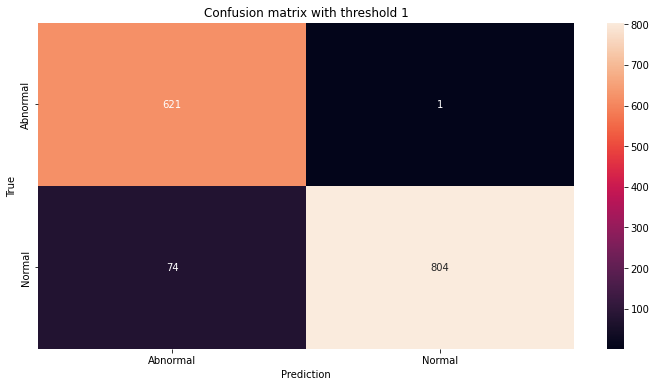

In [104]:
cm = confusion_matrix(y_test_, y_pred_)

fig, ax = plt.subplots(figsize = (12, 6))
sns.heatmap(cm, annot = True, fmt = 'd', ax = ax);
ax.set(title = 'Confusion matrix with threshold 1', 
       xlabel = 'Prediction', ylabel = 'True', 
       xticklabels = ['Abnormal', 'Normal'], yticklabels = ['Abnormal', 'Normal']);

### Prediction with threshold 2

In [105]:
y_pred = predict(autoencoder, X_test, threshold2)
print_stats(y_test, y_pred)

Accuracy =  0.97933
Precision =  0.95814
Recall =  0.99357
F1 score =  0.97553


In [106]:
# Converting the labels to class names
y_test_ = pd.Series(y_test).replace({1: 'Normal', 0: 'Abnormal'})
y_pred_ = pd.Series(y_pred.numpy()).replace({True: 'Normal', False: 'Abnormal'})

In [107]:
print(classification_report(y_test_, y_pred_, digits = 4))

              precision    recall  f1-score   support

    Abnormal     0.9581    0.9936    0.9755       622
      Normal     0.9953    0.9692    0.9821       878

    accuracy                         0.9793      1500
   macro avg     0.9767    0.9814    0.9788      1500
weighted avg     0.9799    0.9793    0.9794      1500



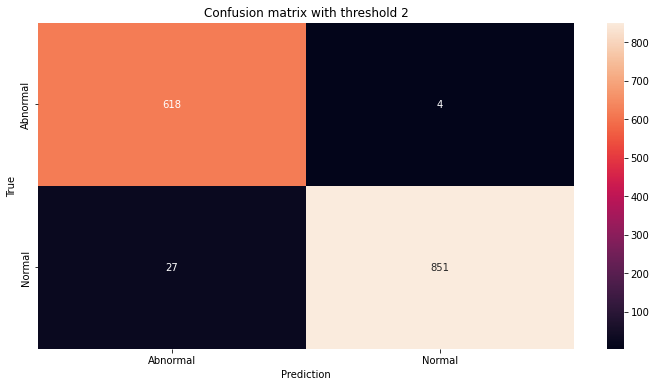

In [108]:
cm = confusion_matrix(y_test_, y_pred_)

fig, ax = plt.subplots(figsize = (12, 6))
sns.heatmap(cm, annot = True, fmt = 'd', ax = ax);
ax.set(title = 'Confusion matrix with threshold 2', 
       xlabel = 'Prediction', ylabel = 'True', 
       xticklabels = ['Abnormal', 'Normal'], yticklabels = ['Abnormal', 'Normal']);

### Results by different thresholds

We can clearly see that the results change based on specified thresholds. **Threshold 1** (1 standard deviation greater than the mean of reconstruction loss) gave us a **recall of 0.9984 and precision of 0.8935**. This means that we were able to identify all of the anomalies except 1 **(great recall)** but we also misidentified 74 normal samples as anomalies **(okay precision)**. This can be a good result if we tried to prioritize identifying every anomaly at all costs but if misidentifying normal samples as anomalies also costs significantly, we would want to improve precision as well. Note that the **F1 score** (the harmonic mean of precision and recall) is **0.9431** which is still decent but can be improved.

**Threshold 2** (with 2 standard deviation greater than the mean of reconstruction loss) gave us a **recall of 0.9936 and precision of 0.9581**. This means that while we identified most of the anomalies, we detected 3 less anomalies than threshold 1 **(lower but still great recall)**. However, we were able to significantly reduce the number of misidentified normal samples as anomalies to 27 from 74 **(much improved precision)**. This can be a good result if we tried to identify most of the anomalies while avoiding misidentifying normal samles as anomalies as much as possible. Note that the **F1 score** signficantly improved to **0.9755**.

Thus, **the choice of threshold** is a major component in anomaly detection and should be chosen **based on what we try to achieve** (improve recall at all costs or decent balance between recall and precision).

## Conclusion

In this notebook, we conducted autoencoder-based anomaly detection and examined the normal heartbeats and those affected by cardiac abnormalities. Autoencoder was able to learn the representations of normal heartbeats and was able to differentiate anomalies well.

We also examined the choice of threshold which is an important component in autoencoder-based anomaly detection. The metrics varied depending on the threshold, where in this particular case, the threshold with 2 standard deviation greater than the mean of reconstruction loss of normal samples was able to achive a balanced precision and recall score with higher f1 score than the threshold with 1 standard deviation greater than the mean.

Through this study, we learned that autoencoder is an effective model in anomaly detection with clear advantage in unsupervised anomaly detection (which is the most common type of anoamly detection) since it only needs to train on normal samples. We also learned that the choice of threshold which greatly affects the result is dependent on the objective of the work (prioritize recall or balance between recall and precision).